# Data Processing

In [1]:
path_train = '../src/data/processed/train_p-w2v_e-1m_p-200_s0.85.csv'
path_val = '../src/data/processed/val_p-w2v_e-1m_p-200_s0.1.csv'
path_test = '../src/data/processed/test_p-w2v_e-1m_p-200_s0.05.csv'

Reading in word vectors. Reduced to 500k due to RAM limits.

**Todo:** Filter for those vocabularies that are actually in the whole data set.

Create a Dataset for the Amazon reviews.

In [2]:
from torch.utils.data import IterableDataset
import torch

class AmazonReviewDatasetWord2Vec(IterableDataset):
    def __init__(self, path):
        
        self._length = 0
        self._path = path

    def __iter__(self):
        return map(self.__process__, open(self._path))
    
    @property
    def length(self):
        if self._length == 0:
            with open(self._path, 'r') as file:
                for line in file:
                    self._length += 1
        return self._length
    
    @staticmethod
    def __process__(line):
        return [int(entry) for entry in line.split(",")]

In [3]:
train_data = AmazonReviewDatasetWord2Vec(path_train)
val_data = AmazonReviewDatasetWord2Vec(path_val)

In [4]:
#%%time
#train_data = AmazonReviewDataset(path_train)

In [5]:
#%%time
#val_data = AmazonReviewDataset(path_val)

Create a DataLoader as well, using a custom collate function for creating the batches.

In [6]:
def batch2tensor(batch):
    X, Y = [None]*len(batch), [None]*len(batch)
    #print(batch)
    #print(len(batch))
    for i, row in enumerate(batch):
        Y[i] = row[0]
        X[i] = row[1:]
        
    return torch.LongTensor(X), torch.LongTensor(Y)

In [7]:
%%time
from torch.utils.data import DataLoader
dataloader_train = DataLoader(train_data, batch_size=8192, num_workers=1, collate_fn=batch2tensor)
dataloader_val = DataLoader(val_data, batch_size=8192, num_workers=1, collate_fn=batch2tensor)

CPU times: user 55 µs, sys: 6 µs, total: 61 µs
Wall time: 64.4 µs


Load one example.

In [8]:
%%time
dataiter_val = iter(dataloader_val)

CPU times: user 4.9 ms, sys: 7.43 ms, total: 12.3 ms
Wall time: 10.5 ms


In [9]:
%%time
X_dash, Y_dash = dataiter_val.next()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 670 ms


In [10]:
%%time
dataiter_train = iter(dataloader_train)

CPU times: user 9.08 ms, sys: 8.14 ms, total: 17.2 ms
Wall time: 31.6 ms


In [11]:
%%time
X_dash, Y_dash = dataiter_train.next()

CPU times: user 6.23 ms, sys: 284 µs, total: 6.52 ms
Wall time: 918 ms


In [12]:
X_dash = X_dash.cuda()
Y_dash = Y_dash.cuda()

In [13]:
X_dash.shape

torch.Size([8192, 200])

In [14]:
Y_dash.shape

torch.Size([8192])

Definition of the network.

In [15]:
import torch.nn as nn

In [16]:
class FFN(nn.Module):
    def __init__(self, word_embeddings, embedding_size=300, padding=200, category_amount=5, dropout=0.25):
        super().__init__()
        
        # Predefined word embeddings
        self.embedding = nn.Embedding.from_pretrained(word_embeddings)
        
        # Dropout
        self.dropout = nn.Dropout(p=dropout)
        
        self.l1 = nn.Linear(embedding_size * padding, 256)
        self.l2 = nn.Linear(256, category_amount)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.embedding(x)
        x = x.view(x.shape[0], -1)
        x = self.l1(x)
        x = self.sigmoid(x)
        x = self.dropout(x)
        x = self.l2(x)
        x = self.softmax(x)
        
        return x

In [17]:
%%time
import gensim
import numpy as np
from transformers import BertTokenizer
tokenizerBert = BertTokenizer.from_pretrained('bert-base-uncased')
embedding_model = gensim.models.KeyedVectors.load_word2vec_format('../src/data/embeddings/GoogleNews-vectors-negative300.bin', binary=True, limit=1_000_000)
embedding_model.add(tokenizerBert._unk_token, np.mean(embedding_model.vectors, axis=0), replace=False)
embedding_model.add(tokenizerBert._pad_token, np.zeros(300),replace=False)

CPU times: user 34.6 s, sys: 4.88 s, total: 39.5 s
Wall time: 38.7 s


In [18]:
model = FFN(torch.FloatTensor(embedding_model.vectors)).cuda()

In [19]:
del tokenizerBert, embedding_model

In [20]:
model

FFN(
  (embedding): Embedding(1000002, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (l1): Linear(in_features=60000, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=5, bias=True)
  (sigmoid): Sigmoid()
  (softmax): LogSoftmax()
)

In [21]:
model(X_dash).shape

torch.Size([8192, 5])

In [22]:
model(X_dash)[0].shape

torch.Size([5])

In [23]:
model(X_dash).shape

torch.Size([8192, 5])

In [24]:
Y_dash.shape

torch.Size([8192])

In [25]:
X_dash.shape

torch.Size([8192, 200])

Look at the untrained model.

In [26]:
from matplotlib import pyplot as plt

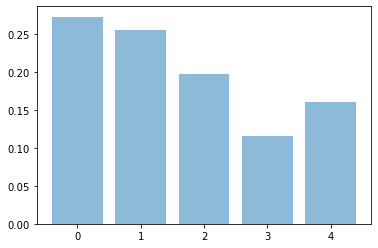

In [27]:
plt.bar(range(0,5), np.exp(model(X_dash).detach().cpu().numpy()[0]), alpha=0.5);

## Training the Model

In [28]:
from torch import optim

In [29]:
#optimizer = optim.SGD(model.parameters(), lr=0.04, nesterov=True, momentum=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.05)

In [30]:
criterion = nn.NLLLoss()

In [31]:
batch_size = 8192

In [32]:
%%time

epochs = 8

train_losses, train_accuracies, validation_losses, validation_accuracies = [], [], [], []

for e in range(epochs):
    
    training_loss = 0
    training_accuracy = 0
    
    i = 0
    
    for X, Y in dataloader_train:
        X = X.cuda()
        Y = Y.cuda()
        
        if i % 20 == 0:
            print("Percentage: {}".format(i * batch_size / 3102500))
    
        # Reset Gradients
        optimizer.zero_grad()
        
        # Forward, Loss, Backwards, Update
        output = model(X)
        loss = criterion(output, Y)
        loss.backward()
        optimizer.step()
        
        # Calculate Metrics
        training_loss += loss.item()
        training_accuracy += torch.sum(torch.exp(output).topk(1)[1].view(-1) == Y).item()
        
        i += 1
        
    else:
        
        print("Evaluating")
        
        validation_loss = 0
        validation_accuracy = 0
        
        model.eval()
        
        with torch.no_grad():
            
            for X, Y in dataloader_val:
                X = X.cuda()
                Y = Y.cuda()
                
                output_validation = model(X)
                loss_val = criterion(output_validation, Y)
                validation_loss += loss_val.item()
                validation_accuracy += torch.sum(torch.exp(output_validation).topk(1, dim=1)[1].view(-1) == Y).item()
        
        training_loss /= train_data.length
        training_accuracy /= train_data.length
        validation_loss /= val_data.length
        validation_accuracy /= val_data.length
        
        # Saving metrics
        train_losses.append(training_loss)
        train_accuracies.append(training_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        
        print("Epoch: {}/{}\n".format(e+1, epochs),
              "Training Loss: {:.6f}\n".format(training_loss),
              "Training Accuracy: {:.3f}\n".format(training_accuracy),
              "Validation Loss: {:.6f}\n".format(validation_loss),
              "Validation Accuracy: {:.3f}\n".format(validation_accuracy))
        
        model.train()

Percentage: 0.0
Percentage: 0.05280902497985496
Percentage: 0.10561804995970991
Percentage: 0.15842707493956487
Percentage: 0.21123609991941983
Percentage: 0.2640451248992748
Percentage: 0.31685414987912974
Percentage: 0.3696631748589847
Percentage: 0.42247219983883966
Percentage: 0.4752812248186946
Percentage: 0.5280902497985496
Percentage: 0.5808992747784045
Percentage: 0.6337082997582595
Percentage: 0.6865173247381144
Percentage: 0.7393263497179694
Percentage: 0.7921353746978244
Percentage: 0.8449443996776793
Percentage: 0.8977534246575343
Percentage: 0.9505624496373892
Evaluating
Epoch: 1/8
 Training Loss: 0.000198
 Training Accuracy: 0.260
 Validation Loss: 0.000187
 Validation Accuracy: 0.308

Percentage: 0.0
Percentage: 0.05280902497985496
Percentage: 0.10561804995970991
Percentage: 0.15842707493956487
Percentage: 0.21123609991941983
Percentage: 0.2640451248992748
Percentage: 0.31685414987912974
Percentage: 0.3696631748589847
Percentage: 0.42247219983883966
Percentage: 0.4752812

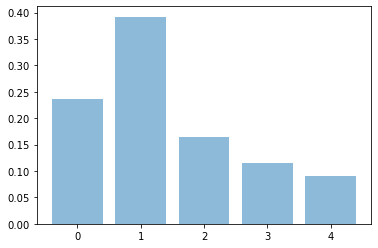

In [33]:
plt.bar(range(0,5), np.exp(model(X_dash).detach().cpu().numpy()[0]), alpha=0.5);

In [34]:
Y_dash[0]

tensor(1, device='cuda:0')

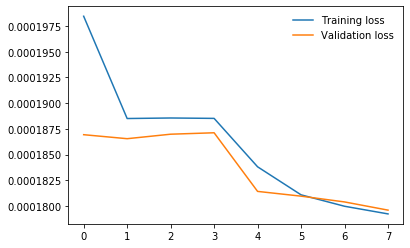

In [35]:
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False);

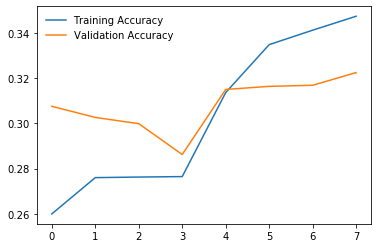

In [36]:
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.legend(frameon=False);

# LSTM

In [ ]:
import torch.nn as nn

In [ ]:
class LSTM(nn.Module):
    def __init__(self, word_embeddings, embedding_size=300, padding=200,
                 category_amount=5, lstm_layers = 2, lstm_hidden = 128,
                 dropout=0.25, lstm_dropout=0.25):
        
        super().__init__()

        self.lstm_layers = lstm_layers
        self.lstm_hidden = lstm_hidden
        
        # Predefined word embeddings
        self.embedding = nn.Embedding.from_pretrained(word_embeddings)
        
        # LSTM
        self.lstm = nn.LSTM(embedding_size, lstm_hidden, lstm_layers,
                           batch_first=True, dropout=lstm_dropout,
                           bidirectional=False)
        
        # Dropout
        self.dropout = nn.Dropout(p=dropout)
        
        # FFN
        self.l1 = nn.Linear(lstm_hidden * padding, category_amount)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):

        hidden = self.init_hidden(x.shape[0])

        # Pass the input tensor through each of our operations
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = self.dropout(x)
        x = x.reshape(x.shape[0], -1)
        x = self.l1(x)
        x = self.sigmoid(x)
        x = self.softmax(x)
        
        return x#, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes lstm_layers x batch_size x lstm_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_hidden).zero_().cuda(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_hidden).zero_().cuda())
        
        return hidden

In [ ]:
import torch

In [ ]:
model = LSTM(torch.FloatTensor(embedding_model.vectors)).cuda()

In [ ]:
model

In [ ]:
#hidden, out = model(X_dash, hidden)
out = model(X_dash)

In [ ]:
out.shape

In [ ]:
from torch import optim
optimizer = optim.SGD(model.parameters(), lr=0.05, nesterov=True, momentum=0.1)
#optimizer = optim.SGD(model.parameters(), lr=0.05)

In [ ]:
criterion = nn.NLLLoss()

In [ ]:
%%time

epochs = 20
clip = 5

train_losses, train_accuracies, validation_losses, validation_accuracies = [], [], [], []

for e in range(epochs):

    # Initialize hidden states
    #hidden = model.init_hidden(1024)
    
    training_loss = 0
    training_accuracy = 0
    
    for X, Y in dataloader_train:
        X = X.cuda()
        Y = Y.cuda()

        #print("Starting batch. {}".format(X.shape))

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        #hidden = tuple([each.data for each in hidden])
    
        # Reset Gradients
        optimizer.zero_grad()
        
        # Forward, Loss, Backwards, Update
        #output, hidden = model(X, hidden)
        output = model(X)
        loss = criterion(output, Y)
        loss.backward()

        # Gradient clipping and update
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        # Calculate Metrics
        training_loss += loss.item()
        training_accuracy += torch.sum(torch.exp(output).topk(1)[1].view(-1) == Y).item()

        #print("Batch done. {}".format(X.shape))
        
    else:
        #print("Validating.")
        # Initialize hidden staes
        model.init_hidden(1024)

        validation_loss = 0
        validation_accuracy = 0
        
        model.eval()
        
        with torch.no_grad():
            for X, Y in dataloader_val:
                X = X.cuda()
                Y = Y.cuda()

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                #val_hidden = tuple([each.data for each in val_hidden])
                
                #output_validation, val_hidden = model(X, val_hidden)
                output_validation = model(X)
                loss_val = criterion(output_validation, Y)
                validation_loss += loss_val.item()
                validation_accuracy += torch.sum(torch.exp(output_validation).topk(1, dim=1)[1].view(-1) == Y).item()
                
        
        training_loss /= len(train_data)
        training_accuracy /= len(train_data)
        validation_loss /= len(val_data)
        validation_accuracy /= len(val_data)
        
        # Saving metrics
        train_losses.append(training_loss)
        train_accuracies.append(training_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        
        print("Epoch: {}/{}\n".format(e+1, epochs),
              "Training Loss: {:.6f}\n".format(training_loss),
              "Training Accuracy: {:.3f}\n".format(training_accuracy),
              "Validation Loss: {:.6f}\n".format(validation_loss),
              "Validation Accuracy: {:.3f}\n".format(validation_accuracy))
        
        model.train()

In [ ]:
from matplotlib import pyplot as plt
plt.bar(range(0,5), np.exp(model(X_dash).detach().cpu().numpy()[0]), alpha=0.5);

In [ ]:
Y_dash[0]

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False);

In [ ]:
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.legend(frameon=False);

# Old

In [ ]:
import pandas as pd 

In [ ]:
train = pd.read_csv("/home/flennic/git/text-mining-project/src/data/processed/train.csv", header=None)
test = pd.read_csv("/home/flennic/git/text-mining-project/src/data/processed/test.csv", header=None) 

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
import logging
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

logger = logging.getLogger(__name__)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

In [ ]:
model.config

In [ ]:
model.eval();

In [ ]:
model.to('cuda');

In [ ]:
input_ids1 = torch.tensor(tokenizer.encode("Hello, my dog is cute".lower(), add_special_tokens=True)).unsqueeze(0).to('cuda')  # Batch size 1
input_ids2 = torch.tensor(tokenizer.encode("Hello, my cat is ugly".lower(), add_special_tokens=True)).unsqueeze(0).to('cuda')  # Batch size 1

In [ ]:
input_ids1.shape

In [ ]:
input_ids = torch.cat((input_ids1, input_ids2))

In [ ]:
input_ids.shape

In [ ]:
labels = torch.tensor([0, 1]).unsqueeze(0).to('cuda')   # Batch size 1

In [ ]:
labels

In [ ]:
outputs = model(input_ids, labels=labels)

In [ ]:
outputs

In [ ]:
loss, logits = outputs[:2]

In [ ]:
import numpy as np

In [ ]:
np.exp(logits.detach().cpu().numpy())

In [ ]:
outputs = model(input_ids)

In [ ]:
outputs

## Raw BERT

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
model.config

In [ ]:
model.eval();

In [ ]:
model.to('cuda');

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', output_hidden_states=True)
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0).to('cuda')  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

In [ ]:
tokenizer.tokenize("Hello, my dog is cute")

In [ ]:
tokenizer.cls_token

In [ ]:
tokenizer.convert_tokens_to_ids("[CLS]")

In [ ]:
input_ids

In [ ]:
outputs[1].shape

In [ ]:
outputs[0].shape

In [ ]:
outputs[0][0, 0,:].shape

In [ ]:
a = ("a", "b", "c")

In [ ]:
b = (1, 2) + a

In [ ]:
b

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
!pwd

In [ ]:
model = KeyedVectors.load_word2vec_format('src/data/embeddings/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
model["hello"].shape